In [ ]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns',200)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import classification_report


## Importing and EDA

In [ ]:
data = pd.read_csv('application_record.csv')
c_record = pd.read_csv('credit_record.csv')

In [ ]:
data.head(3)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0


In [ ]:
c_record.head(3)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0


In [ ]:
data.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [ ]:
c_record.ID.duplicated().sum()

1002590

In [ ]:
data.ID.duplicated().sum()

47

In [ ]:
#Getting the least Month balance value of every unique ID 
start_month=pd.DataFrame(c_record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))

In [ ]:
start_month.shape

(45985, 1)

In [ ]:
start_month.head()

,MONTHS_BALANCE
ID,
5001711,-3
5001712,-18
5001713,-21
5001714,-14
5001715,-59


In [ ]:
#merging the both the application_record data and the start month data
start_month=start_month.rename(columns={'MONTHS_BALANCE':'start_month'}) 
new_data=pd.merge(data,start_month,how="left",on="ID") 

In [ ]:
new_data.shape

(438557, 19)

In [ ]:
new_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,start_month
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0


In [ ]:
#Cheking for duplicates
new_data.ID.duplicated().sum()

47

In [ ]:
#Cheking for value counts of the STATUS column
c_record.STATUS.value_counts()

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

In [ ]:
#Creating a new Risk column
c_record['Risk'] = None
c_record.head()

,ID,MONTHS_BALANCE,STATUS,Risk
0,5001711,0,X,None
1,5001711,-1,0,None
2,5001711,-2,0,None
3,5001711,-3,0,None
4,5001712,0,C,None


In [ ]:
#Assigning values to people with more than 60 days past due
c_record['Risk'][c_record['STATUS'] =='2']='Yes' 
c_record['Risk'][c_record['STATUS'] =='3']='Yes' 
c_record['Risk'][c_record['STATUS'] =='4']='Yes' 
c_record['Risk'][c_record['STATUS'] =='5']='Yes' 

In [ ]:
c_record.head()

,ID,MONTHS_BALANCE,STATUS,Risk
0,5001711,0,X,None
1,5001711,-1,0,None
2,5001711,-2,0,None
3,5001711,-3,0,None
4,5001712,0,C,None


In [ ]:
c_record.Risk.value_counts()

Yes    3104
Name: Risk, dtype: int64

In [ ]:
count=c_record.groupby('ID').count()
count.head()

,MONTHS_BALANCE,STATUS,Risk
ID,,,
5001711,4,4,0
5001712,19,19,0
5001713,22,22,0
5001714,15,15,0
5001715,60,60,0


In [ ]:
#Assigning values based on the count of Risk
count=c_record.groupby('ID').count()
count['Risk'][count['Risk'] > 0]='Yes' 
count['Risk'][count['Risk'] == 0]='No' 
count.Risk.value_counts()

No     45318
Yes      667
Name: Risk, dtype: int64

In [ ]:
p_target = count[['Risk']]
p_target.head()

,Risk
ID,
5001711,No
5001712,No
5001713,No
5001714,No
5001715,No


In [ ]:
#Merging the new created Risk and creating our target variable.
new_data=pd.merge(new_data,p_target,how='inner',on='ID')
new_data['target']=new_data['Risk']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0
new_data['target'] = new_data['target'].astype('object')



In [ ]:
new_data.drop('Risk',axis=1,inplace = True)

In [ ]:
new_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,start_month,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

In [ ]:
new_data.ID.duplicated().sum()

0

In [ ]:
df = new_data.copy()

In [ ]:

df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,start_month,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


In [ ]:
#Converting days to years and renaming the variables.
df['AGE']=-(df['DAYS_BIRTH'])//365	
df['EXP']=-(df['DAYS_EMPLOYED'])//365	
df['EXP'][df['EXP']<0] =np.nan #replace by na
df['EXP'].fillna(df['EXP'].mean(),inplace=True) #replace na by mean

df.head()


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,start_month,target,AGE,EXP
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0,32,12.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0,32,12.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0,58,3.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0,52,8.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0,52,8.0


## Some Visualization

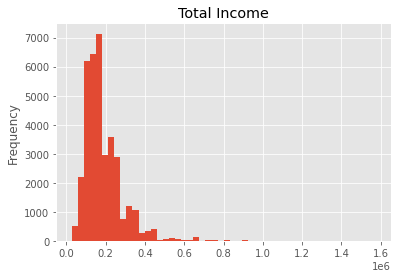

In [ ]:
df['AMT_INCOME_TOTAL'].plot(kind='hist', bins = 50,title='Total Income')
plt.show()

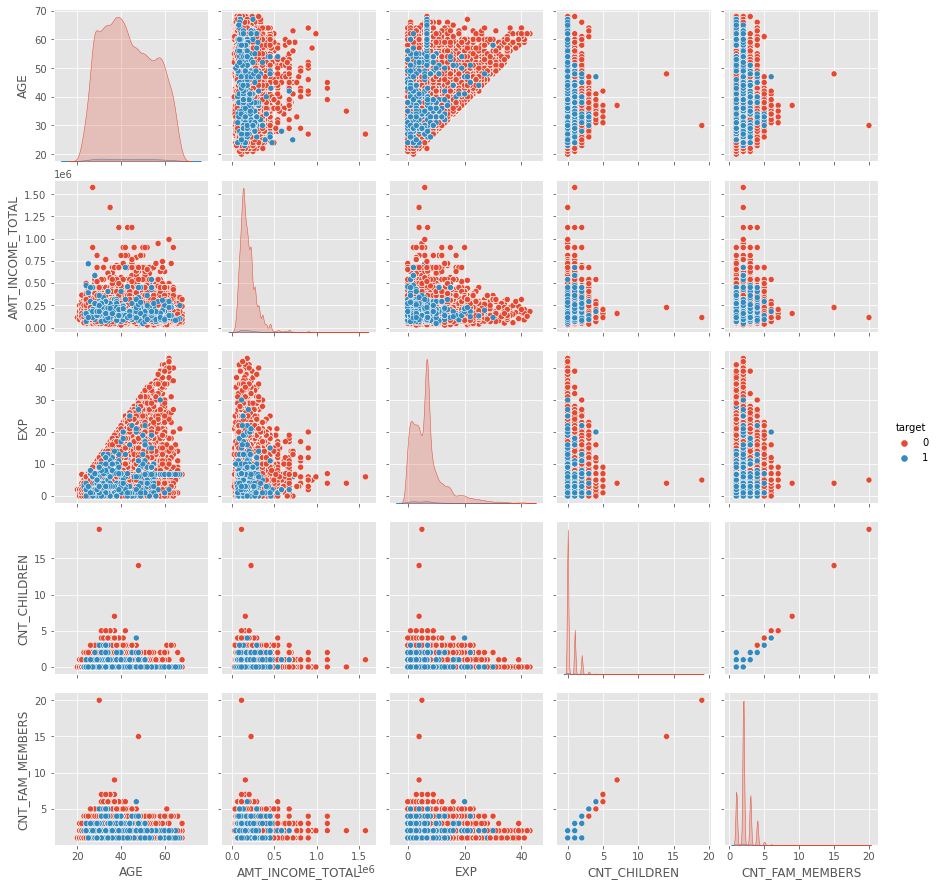

In [ ]:
sns.pairplot(df[['AGE','AMT_INCOME_TOTAL','EXP','CNT_CHILDREN','CNT_FAM_MEMBERS','target']],hue='target')

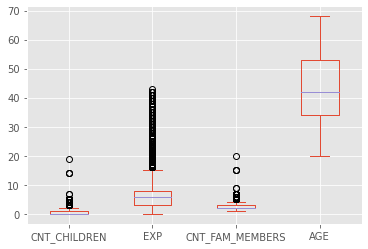

In [ ]:
df[['CNT_CHILDREN','EXP','CNT_FAM_MEMBERS','AGE']].plot(kind='box')
plt.show()

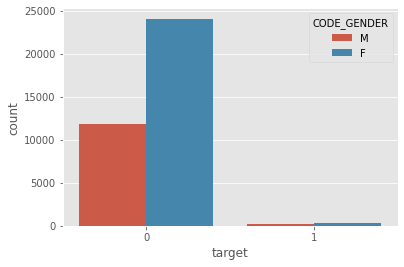

In [ ]:
sns.countplot(data=df, x="target", hue="CODE_GENDER")

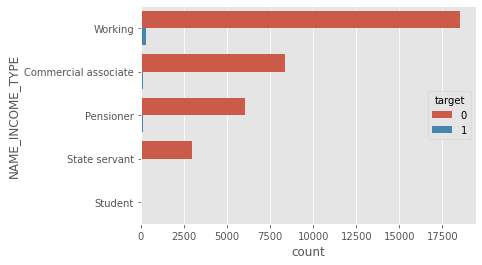

In [ ]:
sns.countplot(data=new_data, y="NAME_INCOME_TYPE", hue="target")

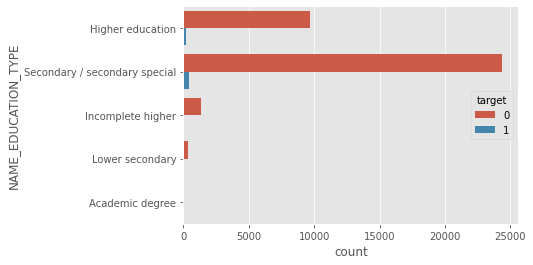

In [ ]:
sns.countplot(data=new_data, y="NAME_EDUCATION_TYPE", hue="target")

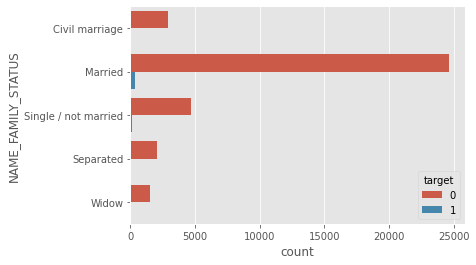

In [ ]:
sns.countplot(data=new_data, y="NAME_FAMILY_STATUS", hue="target")

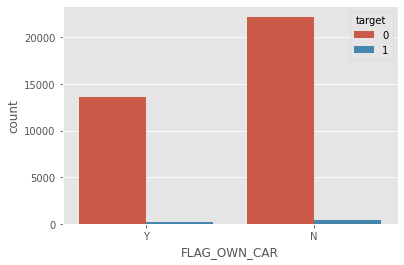

In [ ]:
sns.countplot(data=new_data, x="FLAG_OWN_CAR", hue="target")

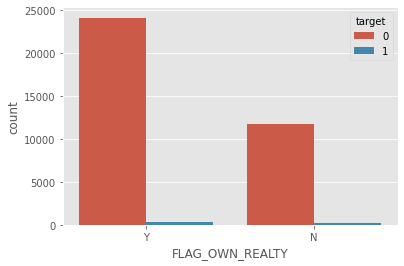

In [ ]:
sns.countplot(data=new_data, x="FLAG_OWN_REALTY", hue="target")

## Preprocessing

In [ ]:
#label encoding binary features.
df['CODE_GENDER'].replace({'F': 0, 'M' : 1}, inplace=True)
df['CODE_GENDER'] = df['CODE_GENDER'].astype('int')

df['FLAG_OWN_CAR'].replace({'N': 0, 'Y' : 1}, inplace=True)
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].astype('int')

df['FLAG_OWN_REALTY'].replace({'N': 0, 'Y' : 1}, inplace=True)
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].astype('int')

df['target'] = df['target'].astype('int')


In [ ]:
new_data['OCCUPATION_TYPE'] =new_data['OCCUPATION_TYPE'].replace(np.nan,'Others')


In [ ]:
#One hot encoding multivalue categorical columns.

categorical_cols = ['NAME_EDUCATION_TYPE','OCCUPATION_TYPE','NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE','NAME_FAMILY_STATUS'] 

df = pd.get_dummies(df, columns = categorical_cols)

In [ ]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,start_month,target,AGE,EXP,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow
0,5008804,1,1,1,0,427500.0,-12005,-4542,1,1,0,0,2.0,-15.0,0,32,12.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
1,5008805,1,1,1,0,427500.0,-12005,-4542,1,1,0,0,2.0,-14.0,0,32,12.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
2,5008806,1,1,1,0,112500.0,-21474,-1134,1,0,0,0,2.0,-29.0,0,58,3.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
3,5008808,0,0,1,0,270000.0,-19110,-3051,1,0,1,1,1.0,-4.0,0,52,8.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,5008809,0,0,1,0,270000.0,-19110,-3051,1,0,1,1,1.0,-26.0,0,52,8.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [ ]:
#dropping unnessecary columns in our dataset.

df.drop(columns=['ID','DAYS_BIRTH','FLAG_MOBIL','DAYS_EMPLOYED','start_month'],inplace=True)
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,target,AGE,EXP,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow
0,1,1,1,0,427500.0,1,0,0,2.0,0,32,12.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
1,1,1,1,0,427500.0,1,0,0,2.0,0,32,12.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
2,1,1,1,0,112500.0,0,0,0,2.0,0,58,3.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,270000.0,0,1,1,1.0,0,52,8.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0,0,1,0,270000.0,0,1,1,1.0,0,52,8.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [ ]:
df.target.value_counts(normalize=True)

0    0.983103
1    0.016897
Name: target, dtype: float64

In [ ]:
def cap_data(df,cols):
    for col in cols:
        print("capping the ",col)
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.01,0.99]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df


In [ ]:
df = cap_data(df,['AMT_INCOME_TOTAL','EXP','CNT_CHILDREN','CNT_FAM_MEMBERS'])

capping the  AMT_INCOME_TOTAL
capping the  EXP
capping the  CNT_CHILDREN
capping the  CNT_FAM_MEMBERS


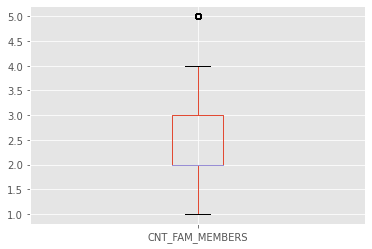

In [ ]:
df[['CNT_FAM_MEMBERS']].boxplot()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 51 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   CODE_GENDER                                        36457 non-null  int64  
 1   FLAG_OWN_CAR                                       36457 non-null  int64  
 2   FLAG_OWN_REALTY                                    36457 non-null  int64  
 3   CNT_CHILDREN                                       36457 non-null  int64  
 4   AMT_INCOME_TOTAL                                   36457 non-null  float64
 5   FLAG_WORK_PHONE                                    36457 non-null  int64  
 6   FLAG_PHONE                                         36457 non-null  int64  
 7   FLAG_EMAIL                                         36457 non-null  int64  
 8   CNT_FAM_MEMBERS                                    36457 non-null  float64
 9   target


## Modeling

In [ ]:
#Separating the variables to predictors and target

X = df.drop('target',axis= 1 ) 
y = df.target 

In [ ]:
X.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,AGE,EXP,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow
0,1,1,1,0,427500.0,1,0,0,2.0,32,12.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
1,1,1,1,0,427500.0,1,0,0,2.0,32,12.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
2,1,1,1,0,112500.0,0,0,0,2.0,58,3.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,270000.0,0,1,1,1.0,52,8.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0,0,1,0,270000.0,0,1,1,1.0,52,8.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [ ]:
#Splitting our data into training and testing sets with a percetange of 20%

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,stratify=y,random_state=42)

In [ ]:
#Cheking for balance in both classes 

print(y_train.value_counts())
print(y_test.value_counts())

0    28672
1      493
Name: target, dtype: int64
0    7169
1     123
Name: target, dtype: int64


In [ ]:
#Standrizing the dataset

ST = StandardScaler()
X_scaled = pd.DataFrame(ST.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(ST.transform(X_test), columns=X_test.columns)


In [ ]:
#Balancing the both the positive and negative records with oversampling.

oversample = SMOTE()
X_balanced, y_balanced = oversample.fit_resample(X_scaled, y_train)
X_test_balanced, y_test_balanced = oversample.fit_resample(X_test_scaled, y_test)


In [ ]:
print(y_balanced.value_counts())
print(y_test_balanced.value_counts())

0    28672
1    28672
Name: target, dtype: int64
0    7169
1    7169
Name: target, dtype: int64


In [ ]:
classifiers = {
    "LogisticRegression" : LogisticRegression(),
    "KNeighbors" : KNeighborsClassifier(),
    "SVC" : SVC(),
    "DecisionTree" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier(),
    "XGBoost" : XGBClassifier()
}

*The next cell takes about 8 minutes to run*

In [ ]:
train_scores = []
test_scores = []

for key, classifier in classifiers.items():
    classifier.fit(X_balanced, y_balanced)
    train_score = classifier.score(X_balanced, y_balanced)
    train_scores.append(train_score)
    test_score = classifier.score(X_test_balanced, y_test_balanced)
    test_scores.append(test_score)

print(train_scores)
print(test_scores)

[0.5896868024553571, 0.9806780133928571, 0.9266008649553571, 0.993896484375, 0.993896484375, 0.9060930524553571]
[0.5265029990235737, 0.7706793137118148, 0.7991351652950203, 0.9156088715301994, 0.9326265866927047, 0.9423211047565909]


## Model of Choice

In [ ]:
xgb = XGBClassifier(max_depth = 8, random_state=42)
model = xgb.fit(X_balanced, y_balanced)
prediction = xgb.predict(X_test_balanced)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_balanced, prediction))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7169
           1       0.99      0.93      0.96      7169

    accuracy                           0.96     14338
   macro avg       0.96      0.96      0.96     14338
weighted avg       0.96      0.96      0.96     14338



In [ ]:
fi = pd.DataFrame(data = model.feature_importances_, index = model.get_booster().feature_names,columns=['importance'])
fi.sort_values('importance',ascending=False).head(10)

,importance
FLAG_OWN_REALTY,0.058031
CODE_GENDER,0.052911
FLAG_OWN_CAR,0.049651
FLAG_PHONE,0.043216
NAME_INCOME_TYPE_Working,0.041352
CNT_CHILDREN,0.040720
NAME_INCOME_TYPE_Pensioner,0.040331
NAME_FAMILY_STATUS_Married,0.038670
OCCUPATION_TYPE_Drivers,0.033586
NAME_INCOME_TYPE_Commercial associate,0.030226


In [ ]:
parameters = {
    'max_depth': range (9, 12, 1),
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.2]
}

In [ ]:
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=parameters,
    scoring = 'roc_auc',
    cv = 5,
    n_jobs = -1,
    verbose=True
)

In [ ]:
grid_search.fit(X_balanced, y_balanced)


In [ ]:
grid_search.best_params_


## Final Model

In [ ]:
final_model = XGBClassifier(learning_rate = 0.2, max_depth= 9, n_estimators= 200, random_state=42)
final_model.fit(X_balanced,y_balanced)
prediction_test = final_model.predict(X_test_balanced)


In [ ]:
prediction_train = final_model.predict(X_balanced)
print(classification_report(y_balanced, prediction_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     28672
           1       0.99      0.99      0.99     28672

    accuracy                           0.99     57344
   macro avg       0.99      0.99      0.99     57344
weighted avg       0.99      0.99      0.99     57344



In [ ]:
print(classification_report(y_test_balanced, prediction_test))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7169
           1       0.99      0.96      0.97      7169

    accuracy                           0.98     14338
   macro avg       0.98      0.98      0.98     14338
weighted avg       0.98      0.98      0.98     14338



In [ ]:
fi = pd.DataFrame(data = final_model.feature_importances_, index = final_model.get_booster().feature_names,columns=['importance'])
fi.sort_values('importance',ascending=False).head(10)

,importance
FLAG_OWN_CAR,0.058073
FLAG_OWN_REALTY,0.053134
CODE_GENDER,0.048120
CNT_CHILDREN,0.044396
FLAG_PHONE,0.043546
NAME_INCOME_TYPE_Commercial associate,0.038623
NAME_HOUSING_TYPE_Office apartment,0.036499
NAME_INCOME_TYPE_Working,0.036059
NAME_INCOME_TYPE_Pensioner,0.033467
FLAG_WORK_PHONE,0.033017
